In [1]:
import pandas as pd

# Load the uploaded EEG dataset
file_path = '/content/EEG.machinelearing_data_BRMH.csv'
eeg_data = pd.read_csv(file_path)

# Display the first few rows to understand the structure
eeg_data.head(), eeg_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945 entries, 0 to 944
Columns: 1149 entries, no. to COH.F.gamma.r.O1.s.O2
dtypes: float64(1144), int64(1), object(4)
memory usage: 8.3+ MB


(   no. sex   age    eeg.date  education     IQ       main.disorder  \
 0    1   M  57.0   2012.8.30        NaN    NaN  Addictive disorder   
 1    2   M  37.0    2012.9.6        6.0  120.0  Addictive disorder   
 2    3   M  32.0   2012.9.10       16.0  113.0  Addictive disorder   
 3    4   M  35.0   2012.10.8       18.0  126.0  Addictive disorder   
 4    5   M  36.0  2012.10.18       16.0  112.0  Addictive disorder   
 
       specific.disorder  AB.A.delta.a.FP1  AB.A.delta.b.FP2  ...  \
 0  Alcohol use disorder         35.998557         21.717375  ...   
 1  Alcohol use disorder         13.425118         11.002916  ...   
 2  Alcohol use disorder         29.941780         27.544684  ...   
 3  Alcohol use disorder         21.496226         21.846832  ...   
 4  Alcohol use disorder         37.775667         33.607679  ...   
 
    COH.F.gamma.o.Pz.p.P4  COH.F.gamma.o.Pz.q.T6  COH.F.gamma.o.Pz.r.O1  \
 0              55.989192              16.739679              23.452271   
 1    

In [2]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Preprocessing: Encode categorical variables and scale EEG features
eeg_data_cleaned = eeg_data.dropna(subset=['main.disorder', 'specific.disorder'])
categorical_columns = ['sex', 'main.disorder', 'specific.disorder']
label_encoders = {col: LabelEncoder() for col in categorical_columns}

# Encode categorical variables
for col in categorical_columns:
    eeg_data_cleaned[col] = label_encoders[col].fit_transform(eeg_data_cleaned[col])

# Separate features and labels
eeg_features = eeg_data_cleaned.drop(columns=categorical_columns + ['no.', 'eeg.date', 'education', 'IQ'])
labels = eeg_data_cleaned[categorical_columns]

# Normalize EEG features
scaler = StandardScaler()
eeg_features_scaled = scaler.fit_transform(eeg_features)

# Combine scaled features and labels
eeg_processed = pd.DataFrame(eeg_features_scaled, columns=eeg_features.columns)
eeg_processed[categorical_columns] = labels.reset_index(drop=True)

# Save the preprocessed data for the CVAE model
eeg_processed_path = '/content/eeg_processed.csv'
eeg_processed.to_csv(eeg_processed_path, index=False)
eeg_processed_path


/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/usr/local/lib/python3.10/dist-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


'/content/eeg_processed.csv'

In [5]:
# Reload the CSV file to inspect the problematic row and column
eeg_processed_debug = pd.read_csv('/content/eeg_processed.csv')

# Identify problematic columns and rows (non-numeric or missing values)
non_numeric_info = eeg_processed_debug.isna().sum()

# Display columns with missing values
non_numeric_info[non_numeric_info > 0]


,0
Unnamed: 122,945


In [8]:
# Remove the problematic column and save the cleaned dataset
eeg_processed_cleaned = eeg_processed_debug.drop(columns=['Unnamed: 122'])
cleaned_data_path = '/content/eeg_processed_cleaned.csv'
eeg_processed_cleaned.to_csv(cleaned_data_path, index=False)

cleaned_data_path


'/content/eeg_processed_cleaned.csv'

In [13]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np

# Define the CVAE model components
class CVAE(tf.keras.Model):
    def __init__(self, input_dim, label_dim, latent_dim):
        super(CVAE, self).__init__()
        self.latent_dim = latent_dim

        # Encoder
        self.encoder = models.Sequential([
            layers.InputLayer(shape=(input_dim + label_dim,)),
            layers.Dense(512, activation='relu'),
            layers.Dense(256, activation='relu'),
            layers.Dense(latent_dim * 2),  # Outputs mean and log variance
        ])

        # Decoder
        self.decoder = models.Sequential([
            layers.InputLayer(shape=(latent_dim + label_dim,)),
            layers.Dense(256, activation='relu'),
            layers.Dense(512, activation='relu'),
            layers.Dense(input_dim, activation='sigmoid'),
        ])

    def encode(self, x):
        mean, logvar = tf.split(self.encoder(x), num_or_size_splits=2, axis=1)
        return mean, logvar

    def reparameterize(self, mean, logvar):
        eps = tf.random.normal(shape=mean.shape)
        return eps * tf.exp(logvar * 0.5) + mean

    def decode(self, z, labels):
        inputs = tf.concat([z, labels], axis=1)
        return self.decoder(inputs)

    def call(self, inputs):
        features, labels = inputs
        inputs = tf.concat([features, labels], axis=1)
        mean, logvar = self.encode(inputs)
        z = self.reparameterize(mean, logvar)
        reconstructed = self.decode(z, labels)
        return reconstructed, mean, logvar

#loss function
def compute_loss(model, features, labels):
    reconstructed, mean, logvar = model((features, labels))
    # Ensure reconstruction loss operates correctly
    reconstruction_loss = tf.reduce_mean(tf.keras.losses.mse(features, reconstructed))
    kl_loss = -0.5 * tf.reduce_mean(1 + logvar - tf.square(mean) - tf.exp(logvar))
    return reconstruction_loss + kl_loss


# Load preprocessed data
data = np.loadtxt('/content/eeg_processed_cleaned.csv', delimiter=',', skiprows=1)
features = data[:, :-3]  # EEG features
labels = data[:, -3:]    # Categorical labels

# Split the data
split_ratio = 0.8
split_index = int(split_ratio * features.shape[0])
train_features, test_features = features[:split_index], features[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

# Model parameters
input_dim = train_features.shape[1]
label_dim = train_labels.shape[1]
latent_dim = 64

# Instantiate and compile the model
cvae = CVAE(input_dim=input_dim, label_dim=label_dim, latent_dim=latent_dim)
optimizer = tf.keras.optimizers.Adam()

# Training the model
epochs = 50
batch_size = 32

dataset = tf.data.Dataset.from_tensor_slices((train_features, train_labels)).shuffle(1000).batch(batch_size)

for epoch in range(epochs):
    for batch_features, batch_labels in dataset:
        with tf.GradientTape() as tape:
            loss = compute_loss(cvae, batch_features, batch_labels)
        gradients = tape.gradient(loss, cvae.trainable_variables)
        optimizer.apply_gradients(zip(gradients, cvae.trainable_variables))

    # Print the loss for each epoch
    print(f"Epoch {epoch + 1}, Loss: {loss.numpy():.4f}")

# Evaluate on the test set
def evaluate_model(model, features, labels):
    reconstructed, _, _ = model((features, labels))
    reconstruction_error = tf.reduce_mean(tf.keras.losses.mse(features, reconstructed))
    return reconstruction_error.numpy()

test_loss = evaluate_model(cvae, test_features, test_labels)
print(f"Test Reconstruction Error: {test_loss:.4f}")


Epoch 1, Loss: 0.8708
Epoch 2, Loss: 0.9882
Epoch 3, Loss: 0.9624
Epoch 4, Loss: 0.8200
Epoch 5, Loss: 1.0438
Epoch 6, Loss: 1.0347
Epoch 7, Loss: 1.1501
Epoch 8, Loss: 0.8155
Epoch 9, Loss: 1.0770
Epoch 10, Loss: 1.1191
Epoch 11, Loss: 0.9010
Epoch 12, Loss: 1.2997
Epoch 13, Loss: 0.9518
Epoch 14, Loss: 1.0647
Epoch 15, Loss: 1.0769
Epoch 16, Loss: 0.9761
Epoch 17, Loss: 1.2416
Epoch 18, Loss: 0.8130
Epoch 19, Loss: 0.9943
Epoch 20, Loss: 1.0180
Epoch 21, Loss: 0.8505
Epoch 22, Loss: 0.8891
Epoch 23, Loss: 0.7209
Epoch 24, Loss: 0.9540
Epoch 25, Loss: 0.9628
Epoch 26, Loss: 0.9042
Epoch 27, Loss: 0.7920
Epoch 28, Loss: 1.0618
Epoch 29, Loss: 0.7963
Epoch 30, Loss: 1.0867
Epoch 31, Loss: 0.6887
Epoch 32, Loss: 0.9809
Epoch 33, Loss: 1.0091
Epoch 34, Loss: 0.7319
Epoch 35, Loss: 0.9336
Epoch 36, Loss: 0.9684
Epoch 37, Loss: 1.4366
Epoch 38, Loss: 0.9084
Epoch 39, Loss: 0.8054
Epoch 40, Loss: 1.0107
Epoch 41, Loss: 0.7491
Epoch 42, Loss: 0.9013
Epoch 43, Loss: 0.9992
Epoch 44, Loss: 1.49

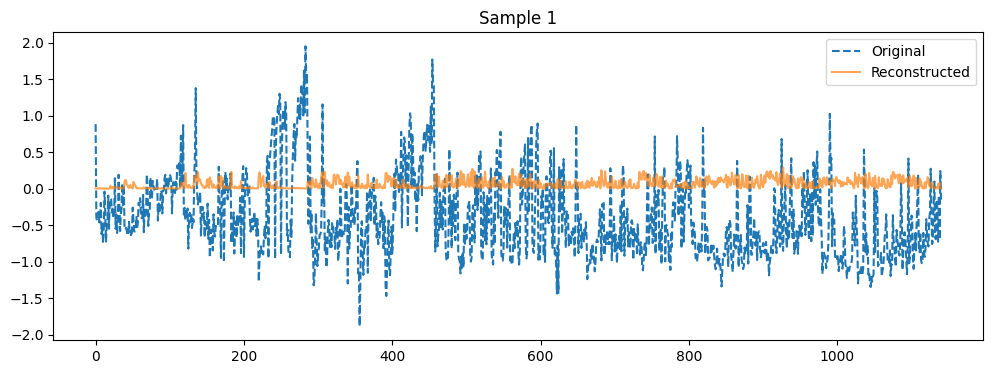

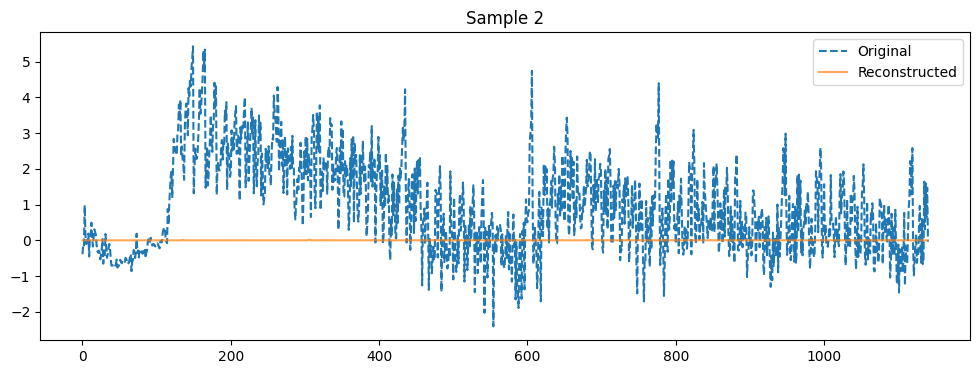

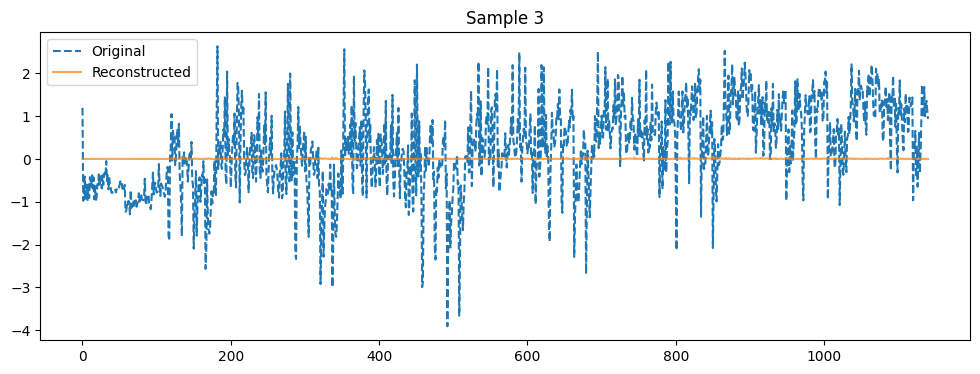

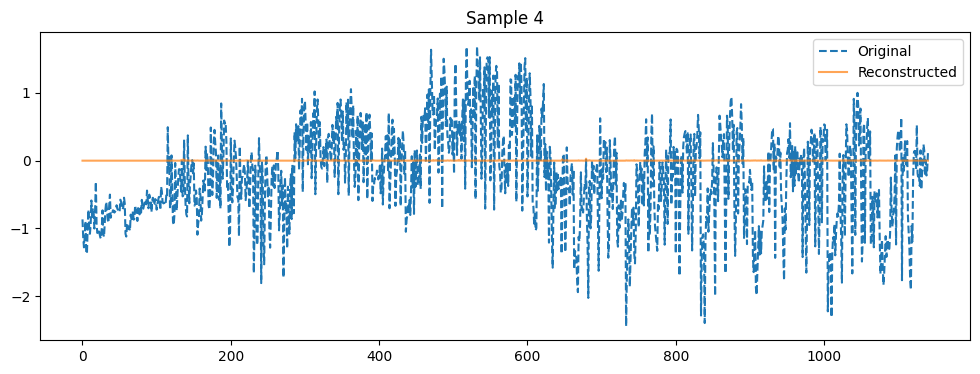

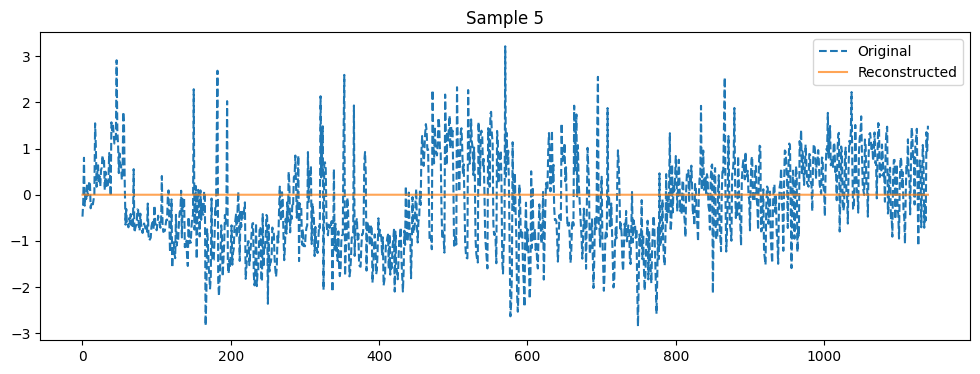

In [14]:
import matplotlib.pyplot as plt

# Randomly select a few samples from the test set
n_samples = 5
indices = np.random.choice(test_features.shape[0], n_samples, replace=False)
original_samples = test_features[indices]
labels_samples = test_labels[indices]

# Reconstruct samples
reconstructed_samples, _, _ = cvae((original_samples, labels_samples))

# Plot original vs reconstructed features
for i in range(n_samples):
    plt.figure(figsize=(12, 4))
    plt.plot(original_samples[i], label="Original", linestyle="--")
    plt.plot(reconstructed_samples[i].numpy(), label="Reconstructed", alpha=0.7)
    plt.title(f"Sample {i + 1}")
    plt.legend()
    plt.show()


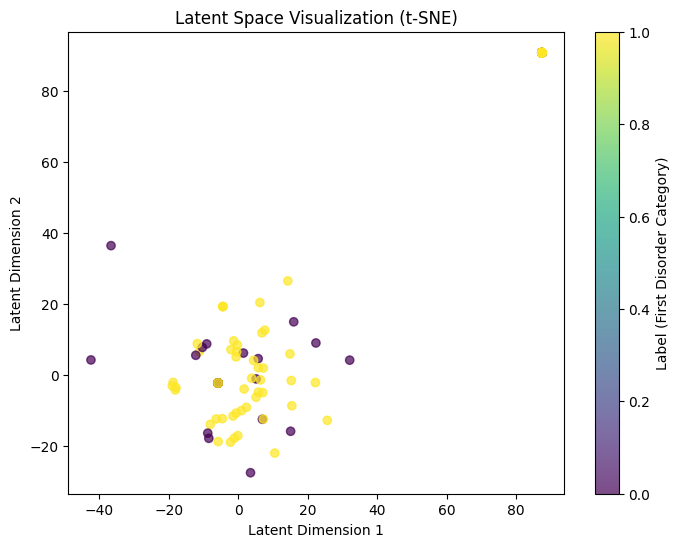

In [15]:
from sklearn.manifold import TSNE

# Encode the test data into the latent space
test_inputs = tf.concat([test_features, test_labels], axis=1)
mean, _ = cvae.encode(test_inputs)
latent_space = mean.numpy()

# Reduce dimensions for visualization
latent_2d = TSNE(n_components=2, random_state=42).fit_transform(latent_space)

# Plot the latent space
plt.figure(figsize=(8, 6))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=test_labels[:, 0], cmap="viridis", alpha=0.7)
plt.colorbar(label="Label (First Disorder Category)")
plt.title("Latent Space Visualization (t-SNE)")
plt.xlabel("Latent Dimension 1")
plt.ylabel("Latent Dimension 2")
plt.show()


In [16]:
reconstruction_errors = tf.reduce_mean(tf.keras.losses.mse(test_features, reconstructed_samples), axis=1).numpy()

plt.figure(figsize=(8, 6))
plt.hist(reconstruction_errors, bins=30, alpha=0.7, color="blue")
plt.title("Reconstruction Error Distribution")
plt.xlabel("Reconstruction Error")
plt.ylabel("Frequency")
plt.show()


InvalidArgumentError: {{function_node __wrapped__Sub_device_/job:localhost/replica:0/task:0/device:GPU:0}} required broadcastable shapes [Op:Sub] name: 